# Задание 2.1 - Нейронные сети

В этом задании вы реализуете и натренируете настоящую нейроную сеть своими руками!

В некотором смысле это будет расширением прошлого задания - нам нужно просто составить несколько линейных классификаторов вместе!

<img src="https://i.redd.it/n9fgba8b0qr01.png" alt="Stack_more_layers" width="400px"/>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_layer_gradient, check_layer_param_gradient, check_model_gradient
from layers import FullyConnectedLayer, ReLULayer
from model import TwoLayerNet
from trainer import Trainer, Dataset
from optim import SGD, MomentumSGD
from metrics import multiclass_accuracy

# Загружаем данные

И разделяем их на training и validation.

In [3]:
def prepare_for_neural_network(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float64) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float64) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    return train_flat, test_flat
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_neural_network(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Как всегда, начинаем с кирпичиков

Мы будем реализовывать необходимые нам слои по очереди. Каждый слой должен реализовать:
- прямой проход (forward pass), который генерирует выход слоя по входу и запоминает необходимые данные
- обратный проход (backward pass), который получает градиент по выходу слоя и вычисляет градиент по входу и по параметрам

Начнем с ReLU, у которого параметров нет.

In [4]:
# TODO: Implement ReLULayer layer in layers.py
# Note: you'll need to copy implementation of the gradient_check function from the previous assignment

X = np.array([[1,-2,3],
              [-1, 2, 0.1]
              ])

assert check_layer_gradient(ReLULayer(), X)

Gradient check passed!


А теперь реализуем полносвязный слой (fully connected layer), у которого будет два массива параметров: W (weights) и B (bias).

Все параметры наши слои будут использовать для параметров специальный класс `Param`, в котором будут храниться значения параметров и градиенты этих параметров, вычисляемые во время обратного прохода.

Это даст возможность аккумулировать (суммировать) градиенты из разных частей функции потерь, например, из cross-entropy loss и regularization loss.

In [5]:
# TODO: Implement FullyConnected layer forward and backward methods
assert check_layer_gradient(FullyConnectedLayer(3, 4), X)
# TODO: Implement storing gradients for W and B
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'W')
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'B')

Gradient check passed!
Gradient check passed!
Gradient check passed!


## Создаем нейронную сеть

Теперь мы реализуем простейшую нейронную сеть с двумя полносвязным слоями и нелинейностью ReLU. Реализуйте функцию `compute_loss_and_gradients`, она должна запустить прямой и обратный проход через оба слоя для вычисления градиентов.

Не забудьте реализовать очистку градиентов в начале функции.

In [6]:
# TODO: In model.py, implement compute_loss_and_gradients function
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 0)
loss = model.compute_loss_and_gradients(train_X[:2], train_y[:2])

# TODO Now implement backward pass and aggregate all of the params
check_model_gradient(model, train_X[:2], train_y[:2])

Checking gradient for 0_W
Gradient check passed!
Checking gradient for 0_B
Gradient check passed!
Checking gradient for 2_W
Gradient check passed!
Checking gradient for 2_B
Gradient check passed!


True

Теперь добавьте к модели регуляризацию - она должна прибавляться к loss и делать свой вклад в градиенты.

In [7]:
# TODO Now implement l2 regularization in the forward and backward pass
model_with_reg = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 1e1)
loss_with_reg = model_with_reg.compute_loss_and_gradients(train_X[:2], train_y[:2])
assert loss_with_reg > loss and not np.isclose(loss_with_reg, loss), \
    "Loss with regularization (%2.4f) should be higher than without it (%2.4f)!" % (loss, loss_with_reg)

check_model_gradient(model_with_reg, train_X[:2], train_y[:2])

Checking gradient for 0_W
Gradient check passed!
Checking gradient for 0_B
Gradient check passed!
Checking gradient for 2_W
Gradient check passed!
Checking gradient for 2_B
Gradient check passed!


True

Также реализуем функцию предсказания (вычисления значения) модели на новых данных.

Какое значение точности мы ожидаем увидеть до начала тренировки?

In [8]:
# Finally, implement predict function!

# TODO: Implement predict function
# What would be the value we expect?
multiclass_accuracy(model_with_reg.predict(train_X[:30]), train_y[:30]) 

0.1

# Допишем код для процесса тренировки

Если все реализовано корректно, значение функции ошибки должно уменьшаться с каждой эпохой, пусть и медленно. Не беспокойтесь пока про validation accuracy.

In [9]:
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate = 1e-2)

# TODO Implement missing pieces in Trainer.fit function
# You should expect loss to go down every epoch, even if it's slow
loss_history, train_history, val_history = trainer.fit()

Epoch 0.000000   Loss: 2.302491, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch 1.000000   Loss: 2.302451, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch 2.000000   Loss: 2.302476, Train accuracy: 0.148222, val accuracy: 0.140000
Epoch 3.000000   Loss: 2.302536, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch 4.000000   Loss: 2.302488, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch 5.000000   Loss: 2.302381, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch 6.000000   Loss: 2.302578, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch 7.000000   Loss: 2.302424, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch 8.000000   Loss: 2.302486, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch 9.000000   Loss: 2.302473, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch 10.000000   Loss: 2.302535, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch 11.000000   Loss: 2.302558, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch 12.00000

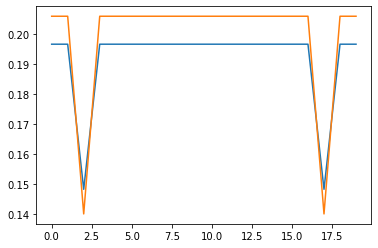

In [10]:
plt.plot(train_history)
plt.plot(val_history)

# Улучшаем процесс тренировки

Мы реализуем несколько ключевых оптимизаций, необходимых для тренировки современных нейросетей.

## Уменьшение скорости обучения (learning rate decay)

Одна из необходимых оптимизаций во время тренировки нейронных сетей - постепенное уменьшение скорости обучения по мере тренировки.

Один из стандартных методов - уменьшение скорости обучения (learning rate) каждые N эпох на коэффициент d (часто называемый decay). Значения N и d, как всегда, являются гиперпараметрами и должны подбираться на основе эффективности на проверочных данных (validation data). 

В нашем случае N будет равным 1.

In [11]:
# TODO Implement learning rate decay inside Trainer.fit method
# Decay should happen once per epoch

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate_decay=0.99)

initial_learning_rate = trainer.learning_rate
loss_history, train_history, val_history = trainer.fit()

assert trainer.learning_rate < initial_learning_rate, "Learning rate should've been reduced"
assert trainer.learning_rate > 0.5*initial_learning_rate, "Learning rate shouldn'tve been reduced that much!"

Epoch 0.000000   Loss: 2.302239, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch 1.000000   Loss: 2.308332, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch 2.000000   Loss: 2.289100, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch 3.000000   Loss: 2.306072, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch 4.000000   Loss: 2.250868, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch 5.000000   Loss: 2.291086, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch 6.000000   Loss: 2.212819, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch 7.000000   Loss: 2.325159, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch 8.000000   Loss: 2.290994, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch 9.000000   Loss: 2.313145, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch 10.000000   Loss: 2.238692, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch 11.000000   Loss: 2.286604, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch 12.00000

# Накопление импульса (Momentum SGD)

Другой большой класс оптимизаций - использование более эффективных методов градиентного спуска. Мы реализуем один из них - накопление импульса (Momentum SGD).

Этот метод хранит скорость движения, использует градиент для ее изменения на каждом шаге, и изменяет веса пропорционально значению скорости.
(Физическая аналогия: Вместо скорости градиенты теперь будут задавать ускорение, но будет присутствовать сила трения.)

```
velocity = momentum * velocity - learning_rate * gradient 
w = w + velocity
```

`momentum` здесь коэффициент затухания, который тоже является гиперпараметром (к счастью, для него часто есть хорошее значение по умолчанию, типичный диапазон -- 0.8-0.99).

Несколько полезных ссылок, где метод разбирается более подробно:  
http://cs231n.github.io/neural-networks-3/#sgd  
https://distill.pub/2017/momentum/

In [12]:
# TODO: Implement MomentumSGD.update function in optim.py

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=1e-4, learning_rate_decay=0.99)

# You should see even better results than before!
loss_history, train_history, val_history = trainer.fit()

Epoch 0.000000   Loss: 2.328003, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch 1.000000   Loss: 2.322595, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch 2.000000   Loss: 2.320111, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch 3.000000   Loss: 2.311517, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch 4.000000   Loss: 2.309783, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch 5.000000   Loss: 2.312030, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch 6.000000   Loss: 2.305316, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch 7.000000   Loss: 2.305544, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch 8.000000   Loss: 2.302871, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch 9.000000   Loss: 2.303209, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch 10.000000   Loss: 2.301828, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch 11.000000   Loss: 2.305645, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch 12.00000

# Ну что, давайте уже тренировать сеть!

## Последний тест - переобучимся (overfit) на маленьком наборе данных

Хороший способ проверить, все ли реализовано корректно - переобучить сеть на маленьком наборе данных.  
Наша модель обладает достаточной мощностью, чтобы приблизить маленький набор данных идеально, поэтому мы ожидаем, что на нем мы быстро дойдем до 100% точности на тренировочном наборе. 

Если этого не происходит, то где-то была допущена ошибка!

In [14]:
data_size = 15
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-1, num_epochs=150, batch_size=5)

# You should expect this to reach 1.0 training accuracy 
loss_history, train_history, val_history = trainer.fit()

Epoch 0.000000   Loss: 2.333937, Train accuracy: 0.200000, val accuracy: 0.066667
Epoch 1.000000   Loss: 2.317794, Train accuracy: 0.266667, val accuracy: 0.066667
Epoch 2.000000   Loss: 2.311414, Train accuracy: 0.333333, val accuracy: 0.066667
Epoch 3.000000   Loss: 2.317738, Train accuracy: 0.266667, val accuracy: 0.000000
Epoch 4.000000   Loss: 2.310963, Train accuracy: 0.266667, val accuracy: 0.000000
Epoch 5.000000   Loss: 2.295162, Train accuracy: 0.266667, val accuracy: 0.000000
Epoch 6.000000   Loss: 2.306700, Train accuracy: 0.266667, val accuracy: 0.000000
Epoch 7.000000   Loss: 2.312951, Train accuracy: 0.266667, val accuracy: 0.000000
Epoch 8.000000   Loss: 2.188086, Train accuracy: 0.400000, val accuracy: 0.000000
Epoch 9.000000   Loss: 2.312709, Train accuracy: 0.400000, val accuracy: 0.000000
Epoch 10.000000   Loss: 2.197881, Train accuracy: 0.400000, val accuracy: 0.000000
Epoch 11.000000   Loss: 1.849126, Train accuracy: 0.400000, val accuracy: 0.000000
Epoch 12.00000

Epoch 99.000000   Loss: 1.232451, Train accuracy: 0.933333, val accuracy: 0.000000
Epoch 100.000000   Loss: 1.129635, Train accuracy: 0.933333, val accuracy: 0.066667
Epoch 101.000000   Loss: 1.255625, Train accuracy: 0.933333, val accuracy: 0.066667
Epoch 102.000000   Loss: 1.277714, Train accuracy: 0.933333, val accuracy: 0.066667
Epoch 103.000000   Loss: 1.272459, Train accuracy: 0.933333, val accuracy: 0.066667
Epoch 104.000000   Loss: 1.544072, Train accuracy: 0.933333, val accuracy: 0.066667
Epoch 105.000000   Loss: 1.074981, Train accuracy: 0.933333, val accuracy: 0.066667
Epoch 106.000000   Loss: 1.221890, Train accuracy: 0.933333, val accuracy: 0.066667
Epoch 107.000000   Loss: 1.508199, Train accuracy: 0.933333, val accuracy: 0.066667
Epoch 108.000000   Loss: 1.265740, Train accuracy: 0.933333, val accuracy: 0.066667
Epoch 109.000000   Loss: 1.093197, Train accuracy: 0.933333, val accuracy: 0.000000
Epoch 110.000000   Loss: 1.078182, Train accuracy: 0.933333, val accuracy: 0.

Теперь найдем гипепараметры, для которых этот процесс сходится быстрее.
Если все реализовано корректно, то существуют параметры, при которых процесс сходится в **20** эпох или еще быстрее.
Найдите их!

In [15]:
# Now, tweak some hyper parameters and make it train to 1.0 accuracy in 20 epochs or less

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 5e-3)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
# TODO: Change any hyperparamers or optimizators to reach training accuracy in 20 epochs
trainer = Trainer(model, dataset, MomentumSGD(momentum = 0.3), learning_rate=6e-1, num_epochs=20, batch_size=120)

loss_history, train_history, val_history = trainer.fit()

Epoch 0.000000   Loss: 2.304164, Train accuracy: 0.200000, val accuracy: 0.133333
Epoch 1.000000   Loss: 2.300611, Train accuracy: 0.200000, val accuracy: 0.133333
Epoch 2.000000   Loss: 2.294768, Train accuracy: 0.333333, val accuracy: 0.133333
Epoch 3.000000   Loss: 2.280846, Train accuracy: 0.333333, val accuracy: 0.066667
Epoch 4.000000   Loss: 2.226447, Train accuracy: 0.333333, val accuracy: 0.066667
Epoch 5.000000   Loss: 2.021206, Train accuracy: 0.333333, val accuracy: 0.000000
Epoch 6.000000   Loss: 1.801513, Train accuracy: 0.266667, val accuracy: 0.000000
Epoch 7.000000   Loss: 1.818511, Train accuracy: 0.333333, val accuracy: 0.000000
Epoch 8.000000   Loss: 1.670517, Train accuracy: 0.533333, val accuracy: 0.000000
Epoch 9.000000   Loss: 1.674403, Train accuracy: 0.466667, val accuracy: 0.000000
Epoch 10.000000   Loss: 1.356496, Train accuracy: 0.533333, val accuracy: 0.000000
Epoch 11.000000   Loss: 1.244227, Train accuracy: 0.533333, val accuracy: 0.133333
Epoch 12.00000

# Итак, основное мероприятие!

Натренируйте лучшую нейросеть! Можно добавлять и изменять параметры, менять количество нейронов в слоях сети и как угодно экспериментировать. 

Добейтесь точности лучше **60%** на validation set.

In [21]:
# Let's train the best one-hidden-layer network we can

from random import choice

n_iterations = 15
num_epochs = 10
learning_rates = [1e-4, 1e-3, 1e-2, 1e-1]
reg_strength = [1e-6, 1e-4, 1e-2]
learning_rate_decay = [0.888, 0.995, 0.999]
hidden_layer_size = [64, 128, 256]
batch_size = [64]
momentums = [0.1, 0.3, 0.5, 0.7, 0.9]

best_classifier = None
best_val_accuracy = 0
best_params = {}

loss_history = []
train_history = []
val_history = []

# TODO find the best hyperparameters to train the network
# Don't hesitate to add new values to the arrays above, perform experiments, use any tricks you want
# You should expect to get to at least 40% of valudation accuracy
# Save loss/train/history of the best classifier to the variables above
for i in range(0, n_iterations):    
    lr = choice(learning_rates)
    reg = choice(reg_strength)
    lrd = choice(learning_rate_decay)
    hs = choice(hidden_layer_size)
    bs = choice(batch_size)
    momentum = choice(momentums)
    
    model = TwoLayerNet(n_input=train_X.shape[1], n_output=10,
                        hidden_layer_size=hs, reg=reg)
    dataset = Dataset(train_X, train_y, val_X, val_y)
    trainer = Trainer(model, dataset, MomentumSGD(momentum=momentum), learning_rate=lr,
                      learning_rate_decay=lrd, num_epochs=num_epochs, batch_size=bs)
    
    print()
    print ("Cycle {}...".format(i+1))
    loss_hist, train_hist, val_hist = trainer.fit()
    
    if val_hist[-1] > best_val_accuracy:
        best_val_accuracy = val_hist[-1]
        best_classifier = model
        
        best_params['learning_rate'] = lr
        best_params['reg_strength'] = reg
        best_params['learning_rate_decay'] = lrd
        best_params['hidden_layer_size'] = hs
        best_params['batch_size'] = bs
        best_params['momentum'] = momentum
        
        loss_history = loss_hist
        train_history = train_hist
        val_history = val_hist

print('best validation accuracy achieved: %f' % best_val_accuracy)


Cycle 1...
Epoch 0.000000   Loss: 2.302630, Train accuracy: 0.114222, val accuracy: 0.147000
Epoch 1.000000   Loss: 2.302254, Train accuracy: 0.114222, val accuracy: 0.147000
Epoch 2.000000   Loss: 2.302047, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch 3.000000   Loss: 2.301775, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch 4.000000   Loss: 2.301768, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch 5.000000   Loss: 2.302024, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch 6.000000   Loss: 2.302057, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch 7.000000   Loss: 2.302234, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch 8.000000   Loss: 2.300127, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch 9.000000   Loss: 2.301736, Train accuracy: 0.196667, val accuracy: 0.206000

Cycle 2...
Epoch 0.000000   Loss: 2.304545, Train accuracy: 0.113333, val accuracy: 0.147000
Epoch 1.000000   Loss: 2.304309, Train accuracy: 0.114444, val accuracy: 0

Epoch 9.000000   Loss: 2.077981, Train accuracy: 0.196667, val accuracy: 0.206000

Cycle 11...
Epoch 0.000000   Loss: 2.302465, Train accuracy: 0.099000, val accuracy: 0.093000
Epoch 1.000000   Loss: 2.302379, Train accuracy: 0.099000, val accuracy: 0.093000
Epoch 2.000000   Loss: 2.302036, Train accuracy: 0.111667, val accuracy: 0.099000
Epoch 3.000000   Loss: 2.302155, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch 4.000000   Loss: 2.301525, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch 5.000000   Loss: 2.302058, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch 6.000000   Loss: 2.301061, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch 7.000000   Loss: 2.300715, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch 8.000000   Loss: 2.301486, Train accuracy: 0.196667, val accuracy: 0.206000
Epoch 9.000000   Loss: 2.301106, Train accuracy: 0.196667, val accuracy: 0.206000

Cycle 12...
Epoch 0.000000   Loss: 2.302559, Train accuracy: 0.062333, val accuracy:

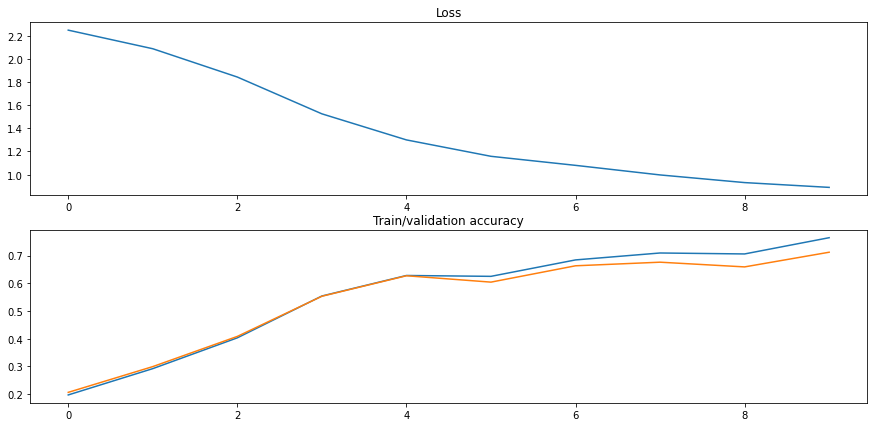

In [22]:
plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.title("Loss")
plt.plot(loss_history)
plt.subplot(212)
plt.title("Train/validation accuracy")
plt.plot(train_history)
plt.plot(val_history)

# Как обычно, посмотрим, как наша лучшая модель работает на тестовых данных

In [23]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Neural net test set accuracy: %f' % (test_accuracy, ))

Neural net test set accuracy: 0.666000
